# CH3. 비지도 그래프 학습(얕은 임베딩 방법)

김보람  
2023-04-06

# ref

-   [그래프
    머신러닝](https://product.kyobobook.co.kr/detail/S000200738068)

-   [github](https://github.com/PacktPublishing/Graph-Machine-Learning)

-   비지도 알고리즘은 스스로 클러스터를 찾고, 패턴 발견, 이상치 감지

# 얕은 임베딩 방법

-   그래프 노드 임베딩을 계싼할때 행렬분해 사용

In [3]:
import matplotlib.pyplot as plt

def draw_graph(G, node_names={}, node_size=500):
    pos_nodes = nx.spring_layout(G)   # 노드를 2D좌표로 
    nx.draw_networkx(G, pos_nodes, with_labels=True, node_size=node_size, edge_color='gray', arrowsize=30)
                          #라벨 이름 그래프표현                 
    
    pos_attrs = {}  # 노드 이름 그래프 위에 그리기 
    for node, coords in pos_nodes.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.08)
        
    #nx.draw_networkx_labels(G, pos_attrs, font_family='serif', font_size=20)
    
    plt.axis('off')  #X축,Y축 눈금 제거
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])   #x축 범위 1.2배
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.show()

## 그래프 분해(Graph Factorization)

-   그래프의 인접 행렬을 분해하여 노드 및 엣지에 대한 임베딩을 생성

-   행렬 분해 알고리즘을 사용하며, 높은 차원의 임베딩 생성 가능

-   단점으로는 계산 복잡도가 높고, 대규모 그래프에서는 적용이 어려울 수
    있음

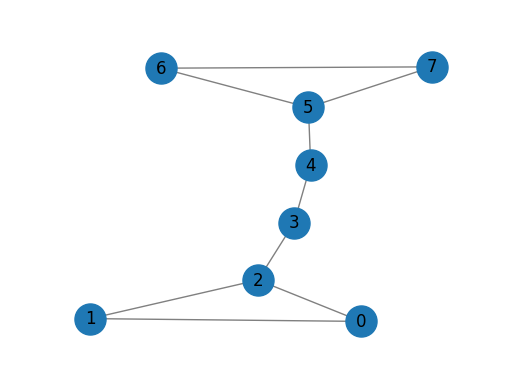

In [4]:
import networkx as nx

G = nx.barbell_graph(m1=3, m2=2)
draw_graph(G)

In [5]:
from pathlib import Path
Path("gem/intermediate").mkdir(parents=True, exist_ok=True)

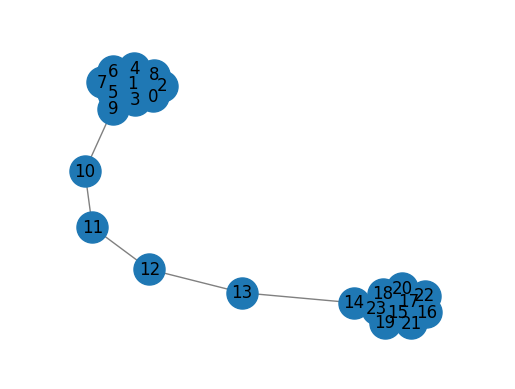

./gf not found. Reverting to Python implementation. Please compile gf, place node2vec in the path and grant executable permission

In [8]:
from gem.embedding.gf import GraphFactorization

G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

gf = GraphFactorization(d=2,  data_set=None,max_iter=10000, eta=1*10**-4, regu=1.0)  #2차원 임베딩 공간 생성
gf.learn_embedding(G)

-   `max_iter`: 최대 반복 횟수

-   `eta`: 학습률

-   `regu`: 정규화 계수

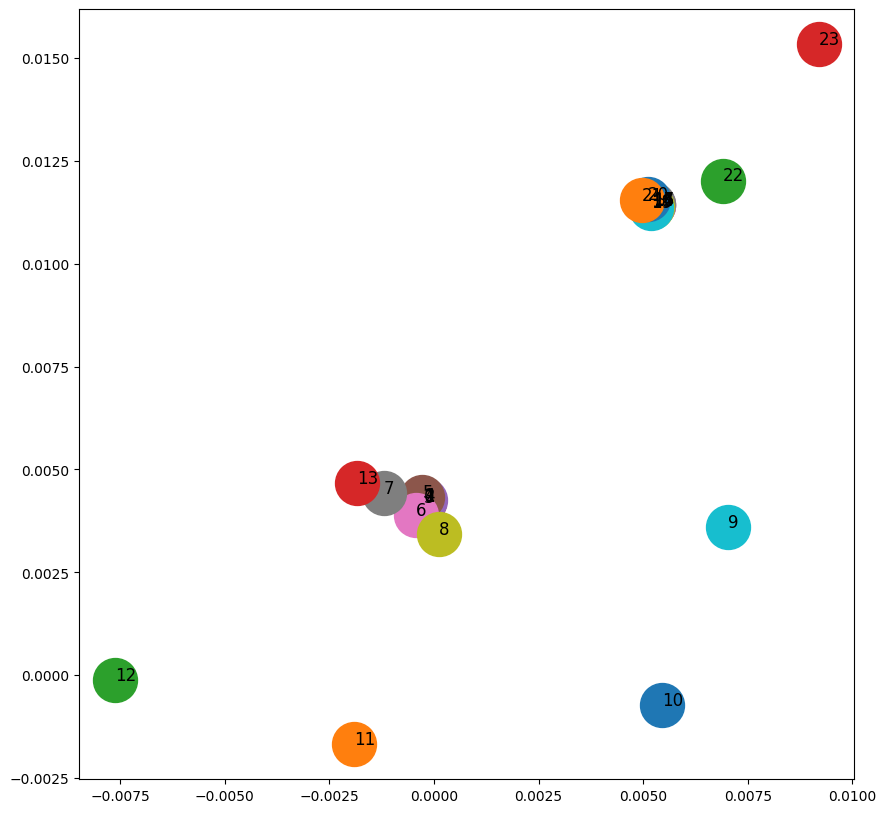

In [9]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

for x in G.nodes():
    
    v = gf.get_embedding()[x]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=12)

## 고차 근접 보존 임베딩(HOPE)

-   고차 근접성 유지, 임베딩 대칭 속성 강제X

-   그래프의 2차원 행렬을 생성하여 노드 및 엣지에 대한 임베딩을 생성

-   그래프의 고차원 구조를 보존하기 위해 그래프의 라플라시안 행렬을
    이용하여 행렬 생성

-   계산이 간단하고, 다양한 유형의 그래프에 적용 가능

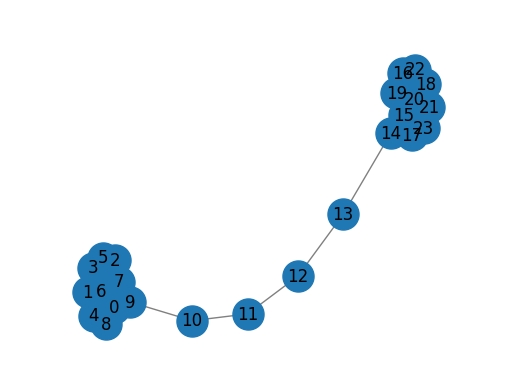

SVD error (low rank): 0.052092

In [15]:
import networkx as nx
from gem.embedding.hope import HOPE

G = nx.barbell_graph(m1=10, m2=4)  #바벨 그래프 생성
draw_graph(G)

hp = HOPE(d=4, beta=0.01)
hp.learn_embedding(G)

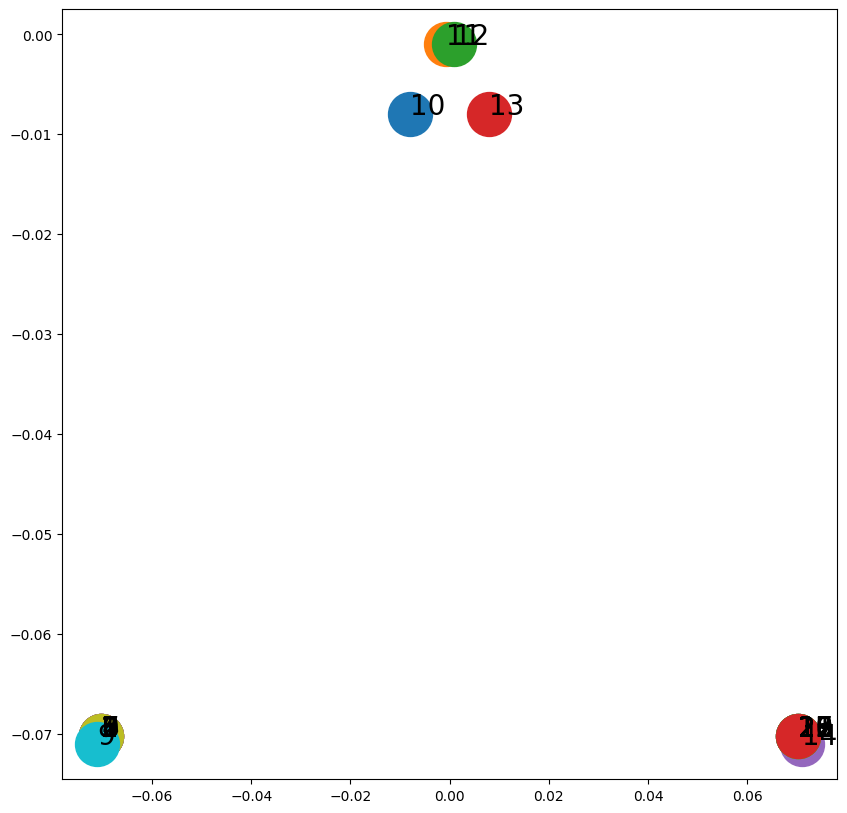

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

for x in G.nodes():
    
    v = hp.get_embedding()[x,2:]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=20)

-   방향이 없으므로 원천 노드와 대상 노드 간에 차이가 없다.

## 전역 구조 정보를 통한 그래프 표현(GraphRep)

-   그래프를 분해하여 노드 및 엣지의 임베딩을 생성

-   그래프의 구조 정보와 노드의 속성 정보를 동시에 고려하여 임베딩 생성

-   다양한 유형의 그래프에 적용 가능하며, 다른 방법들에 비해 높은 임베딩
    품질을 보장

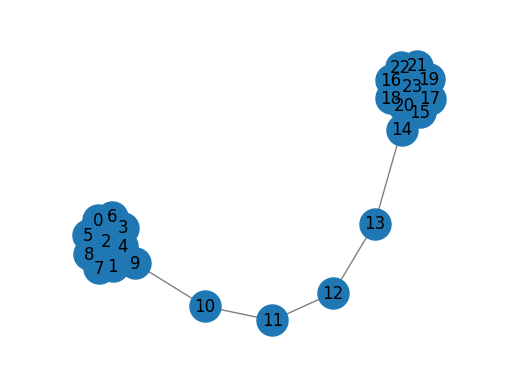

In [18]:
import networkx as nx
from karateclub.node_embedding.neighbourhood.grarep import GraRep

G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

gr = GraRep(dimensions=2,order=3)  #dimension:임베딩 공간 차수, order:노드사이의 최대 근접 차수
gr.fit(G)

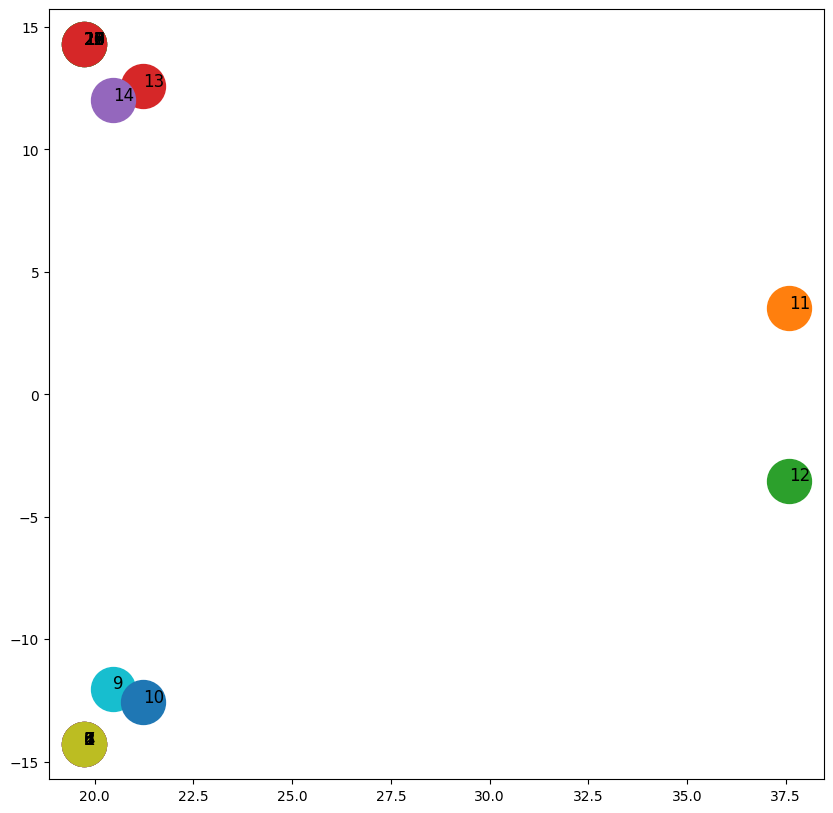

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

ida = 4 #4번째와 5번째
idb = 5
for x in G.nodes():
    
    v = gr.get_embedding()[x]
    ax.scatter(v[ida],v[idb], s=1000)
    ax.annotate(str(x), (v[ida],v[idb]), fontsize=12)

## DeepWalk

-   노드 간의 구조적 유사성을 학습하여 노드를 저차원 벡터로 표현

-   노드가 깊이 우선 탐색(DFS) 방식으로 샘플링된 문맥을 윈도우로 사용해
    노드의 임베딩 학습

-   무방향성 그래프에서 랜덤 워크를 수행(무작위 경로 생성)하여, 노드의
    이웃 노드를 샘플링하고 이를 바탕으로 임베딩 생성

-   이웃 노드를 샘플링할 때, 유사한 패턴의 노드를 더 많이 샘플링하여
    군집 구조 정보를 잘 반영

-   계산이 간단하고, 다양한 유형의 그래프에 적용 가능

`-` 그래프 생성 알고리즘

`1` 랜덤 워크 생성: 입력 그래프 $G$의 각 노드에 대해 고정된 최대
길이($t$)를 갖는 랜덤 워크 세트 계산

`2` skip-gram학습

`3` 임베딩 생성

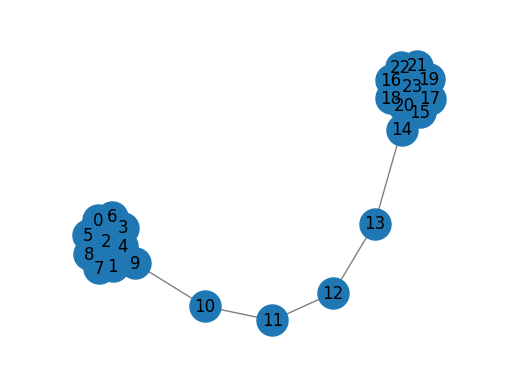

In [22]:
import networkx as nx
from karateclub.node_embedding.neighbourhood.deepwalk import DeepWalk

G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

dw = DeepWalk(dimensions=2)
dw.fit(G)

-   DeepWalkr가 영역 1을 영역 3과 분리

-   영역 2에 속하는 노드에 의해서 오염됬고 임베딩 공간에서 명확한 구분이
    보이지 않는다.

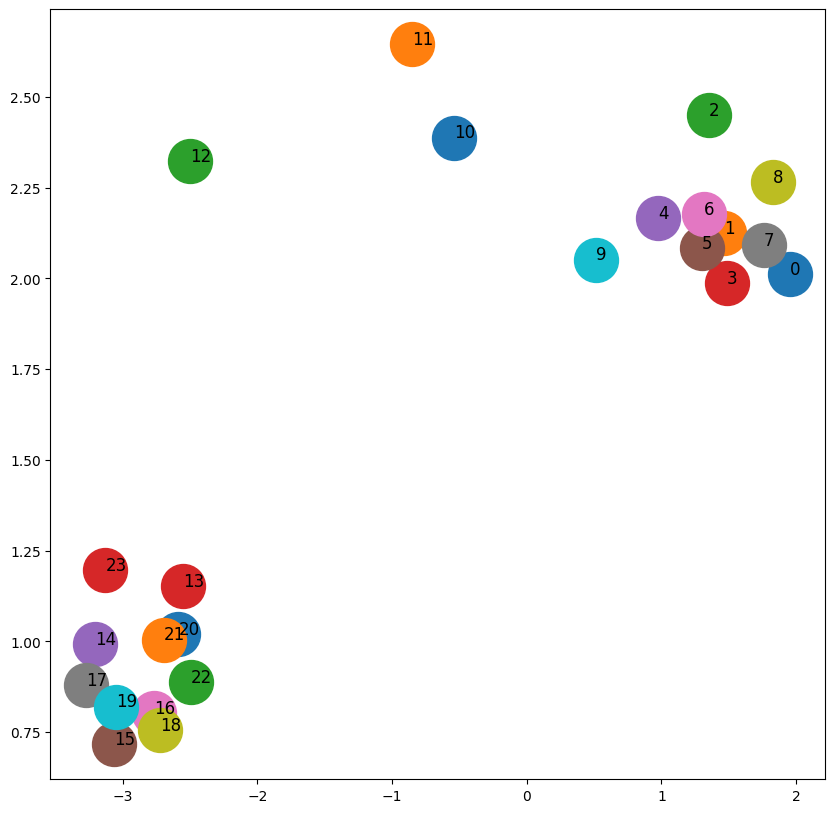

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

for x in G.nodes():
    
    v = dw.get_embedding()[x]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=12)

## Node2Vec

-   랜덤워크를 그래프에 편향된 무작위경로 생성

-   랜덤 워크를 수행하여 **노드**에 대한 임베딩을 생성

-   노드 간의 구조적 유사성과 동시에 노드의 속성 정보를 고려하여
    임베딩을 생성

-   랜덤 워크 수행 시, 노드의 탐색 패턴을 조절하는 파라미터를 추가하여
    다양한 유형의 그래프에서 임베딩 품질을 조정할 수 있음

-   다양한 그래프 분석 및 예측에 적용 가능

-   너비 우선 탐색(BFS), 깊이 우선 탐색(DFS)을 병합해 그래프 탐색

-   `p` 랜덤 워크가 이전 노드로 돌아갈 확률

-   `q` 랜덤 워크가 새로운 노드로 통과할 확률

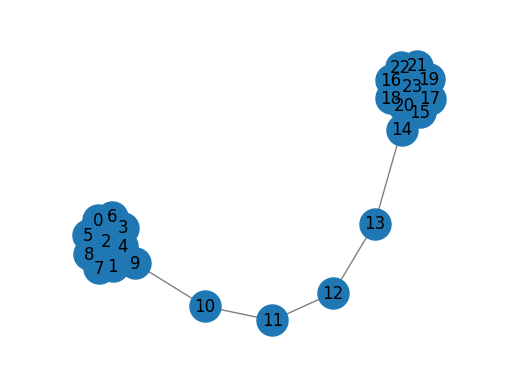

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 231.58it/s]

In [28]:
import networkx as nx
from node2vec import Node2Vec

G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

node2vec = Node2Vec(G, dimensions=2)
model = node2vec.fit(window=10)
embeddings = model.wv

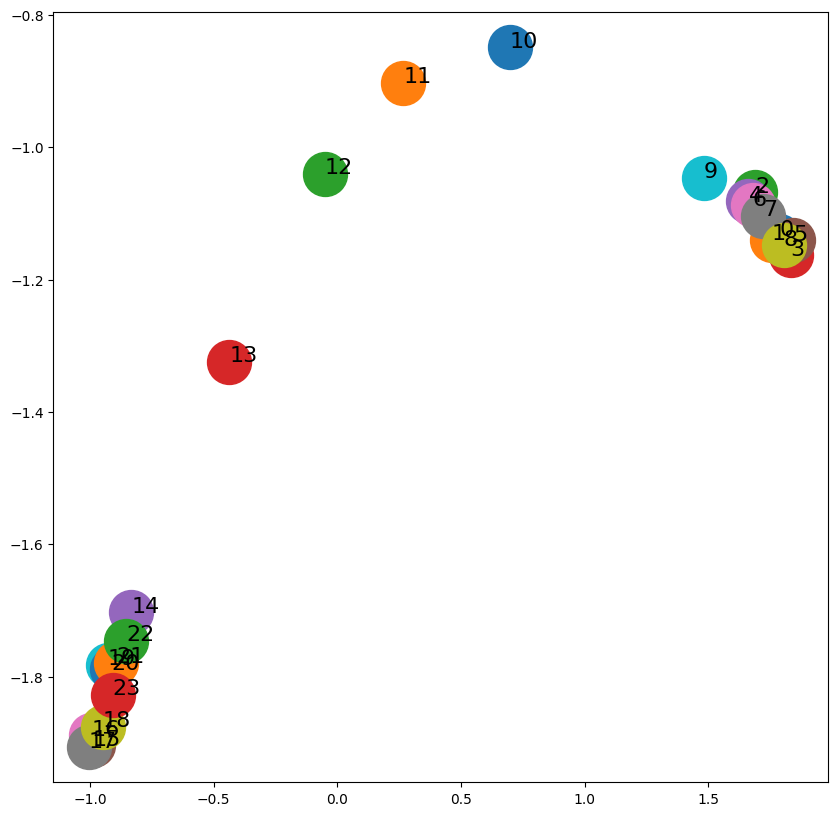

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

for x in G.nodes():
    
    v = model.wv[str(x)]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=16)

plt.show()

-   DeepWalk에 비해 임베딩 공간에서 노드 간 더 나은 분리도

## Edge2Vec

-   랜덤 워크를 수행하여 **엣지**에 대한 임베딩을 생성

-   노드-엣지-노드 패턴을 이용하여 엣지의 구조 정보를 고려하여 임베딩
    생성

-   노드 및 엣지 분석에 적용 가능

-   $v_i, v_j$ : 인접한 노드

-   $f(v_i), f(v_j)$ : Node2Vec으로 계산된 임베딩

| 연산자   | 방정식                     | 클래스이름         |
|----------|----------------------------|--------------------|
| 평균     | $\dfrac{f(v_i)+f(v_j)}{2}$ | AverageEmbedder    |
| 아다마르 | $f(v_i)*f(v_j)$            | HamamarEmbedder    |
| L1가중   | $|f(v_i)-f(v_j)|$          | WeightedL1Embedder |
| L2가중   | $|f(v_i)-f(v_j)|^2$        | WeightedL2Embedder |

`-` HadamardEmbedder

In [30]:
from node2vec.edges import HadamardEmbedder
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

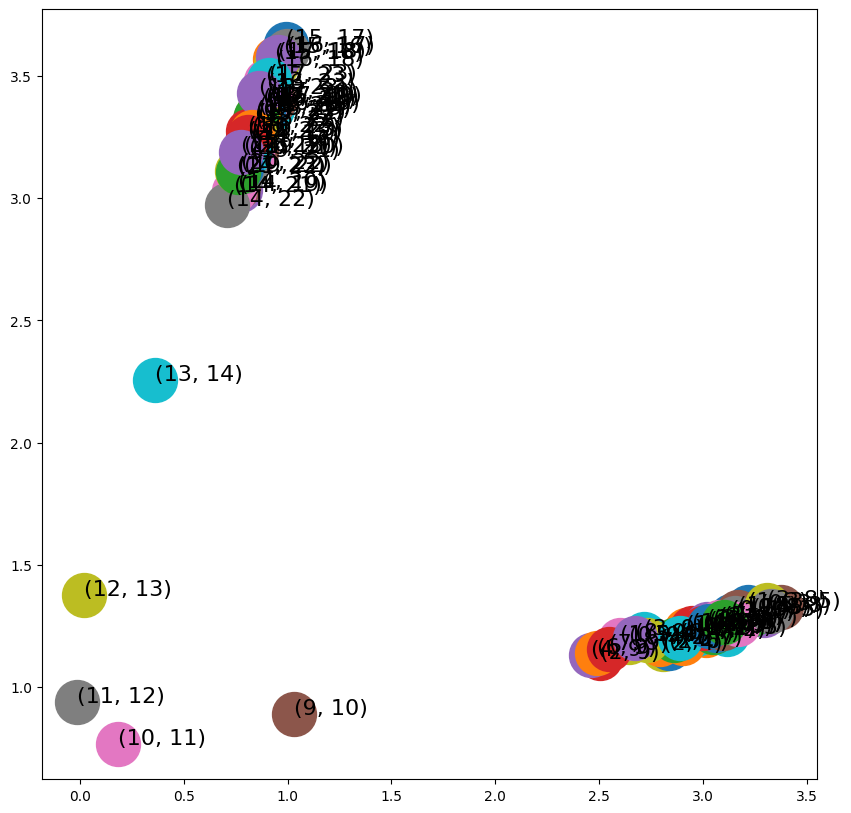

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

for x in G.edges():
    
    v = edges_embs[(str(x[0]), str(x[1]))]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=16)

plt.show()

`-` WeightedL1Embedder

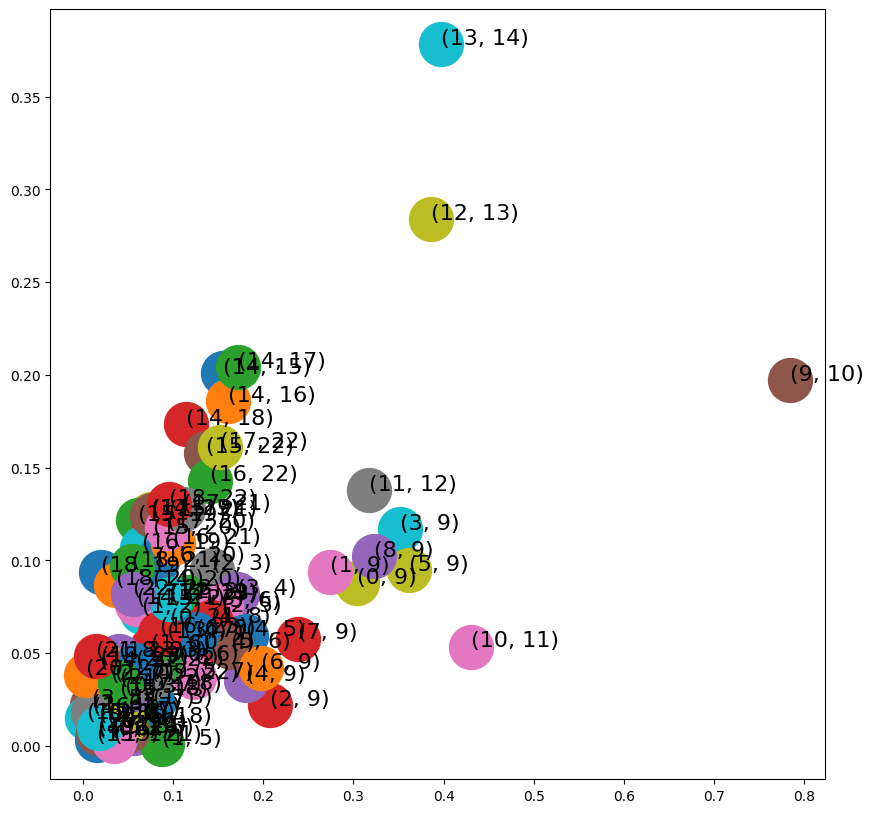

In [32]:
from node2vec.edges import WeightedL1Embedder

edges_embs2 = WeightedL1Embedder(keyed_vectors=model.wv)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

for x in G.edges():
    
    v = edges_embs2[(str(x[0]), str(x[1]))]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=16)

plt.show()


`-` WeightedL2Embedder

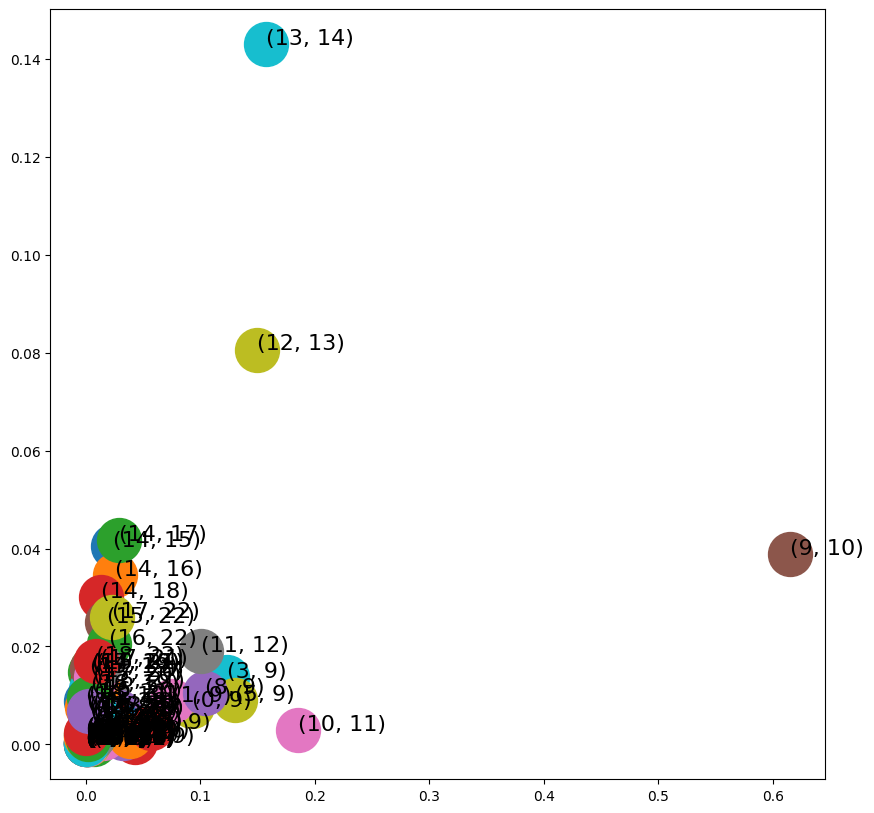

In [33]:
from node2vec.edges import WeightedL2Embedder

edges_embs3 = WeightedL2Embedder(keyed_vectors=model.wv)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

for x in G.edges():
    
    v = edges_embs3[(str(x[0]), str(x[1]))]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=16)

plt.show()


## Graph2Vec

-   주어진 그래프 세트에서 각 점이 그래프를 나타내는 임베딩 공간 생성

-   그래프 자체를 벡터화하여 그래프에 대한 임베딩을 생성

-   전체그래프의 구조 정보와 그래프 내 노드 및 엣지의 속성 정보를
    고려하여 임베딩 생성

-   그래프 분류 및 유사도 측정에 적용 가능

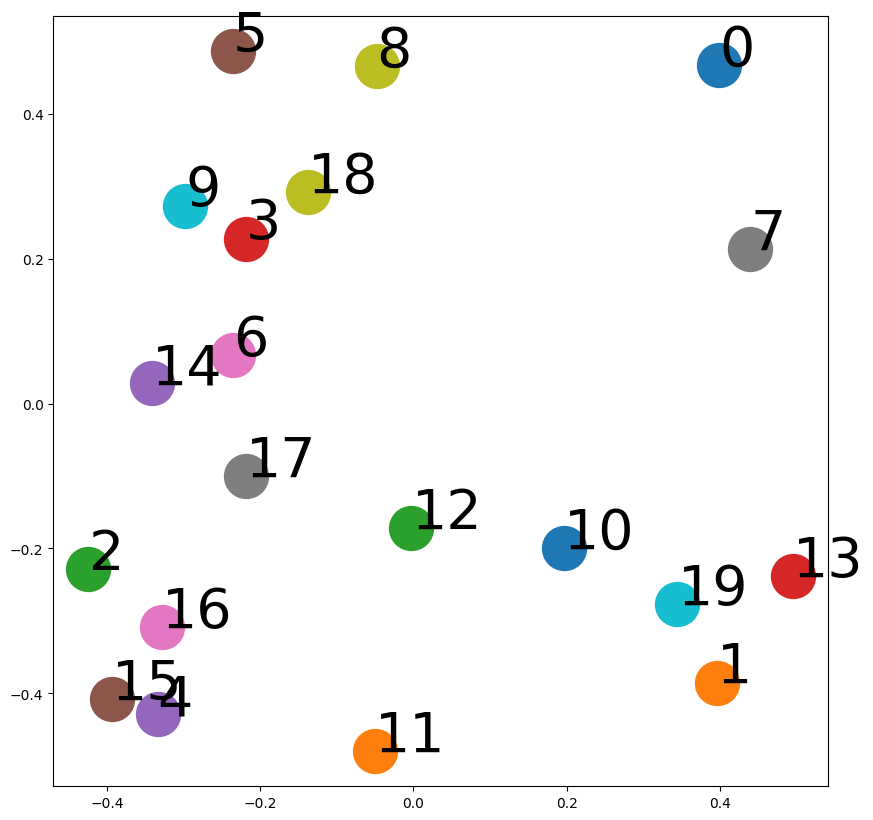

In [35]:
import random
import matplotlib.pyplot as plt
from karateclub import Graph2Vec

n_graphs = 20

def generate_radom():
    n = random.randint(6, 20)
    k = random.randint(5, n)
    p = random.uniform(0, 1)
    return nx.watts_strogatz_graph(n,k,p), [n,k,p]   #20개의 watts_strogatz 그래프 생성

Gs = [generate_radom() for x in range(n_graphs)]

model = Graph2Vec(dimensions=2, wl_iterations=10) #2차원으로 초기화 

# 학습
model.fit([x[0] for x in Gs])
embeddings = model.get_embedding()

fig, ax = plt.subplots(figsize=(10,10))

for i,vec in enumerate(embeddings):
    
    ax.scatter(vec[0],vec[1], s=1000)
    ax.annotate(str(i), (vec[0],vec[1]), fontsize=40)